<div class="alert alert-block alert-success">
FASE 1: CARGA DE DATOS, TRATAMIENTO, LIMPIADO Y CREACIÓN DE DATAFRAME FINAL
<br><br>FASE 2: ANÁLISIS VARIABLES, FEATURES SELECTION
<br><br>FASE 3: DEFINICIÓN FUNCIONES MACHINE LEARNING Y APLICACIÓN DE MODELOS
<br><br>FASE 4: CONCLUSIONES
</div>

<div class="alert alert-block alert-success">
FASE 1
</DIV>

<div class="alert alert-block alert-info"> 
LIBRERIAS
</div>

In [2]:
import pandas as pd
import numpy as np
import time, datetime
import math
import warnings
import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns
import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.datasets import load_boston, load_iris
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestClassifier
from sklearn import preprocessing, cross_validation, svm
import xgboost as xgb
from sklearn.preprocessing import MinMaxScaler
min_max_scaler = MinMaxScaler()

#METRICAS
from sklearn import metrics 

# FEATURES SELECTION
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

#from sklearn.model_selection import TimeSeriesSplit

In [3]:
%pylab inline
%matplotlib inline
style.use('ggplot')
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


<div class="alert alert-block alert-info">
CARGA DE DATOS
</div>

In [4]:
# FICHERO ALOJADO EN http://dreamlife.es\ripple29Mayo.csv
ruta = "C:\\Users\\juan.roncero\\Desktop\\Master ML\\Proyecto Final\\Data\\ripple29Mayo.csv"
dfTransacciones = pd.read_csv(ruta,delimiter=";", decimal=",")

ruta = "C:\\Users\\juan.roncero\\Desktop\\Master ML\\Proyecto Final\\Data\\ballenas.csv"
dfTransBallenas = pd.read_csv(ruta,delimiter=";", decimal=",")

ruta = "C:\\Users\\juan.roncero\\Desktop\\Master ML\\Proyecto Final\\Data\\tweets.csv"
dfTweets = pd.read_csv(ruta,delimiter=";", decimal=",")

<div class="alert alert-block alert-info">
TRATAMIENTO DE DATOS
</div> 

In [5]:
# TRANSFORM
dfTransacciones["FECHA"] = pd.to_datetime(dfTransacciones["FECHA"])
dfTransacciones.index = pd.to_datetime(dfTransacciones["FECHA"], unit='s')
dfTransacciones = dfTransacciones.sort_values('FECHA')

dfTransBallenas["FECHA"] = dfTransBallenas["FECHA_OPERACION"]
dfTransBallenas["FECHA"] = pd.to_datetime(dfTransBallenas["FECHA"])
dfTransBallenas.index = pd.to_datetime(dfTransBallenas["FECHA"], unit='s')
dfTransBallenas = dfTransBallenas.sort_values('FECHA')

dfTweets["FECHA"] = pd.to_datetime(dfTweets["FECHA"])
dfTweets.index = pd.to_datetime(dfTweets["FECHA"], unit='s')
dfTweets = dfTweets.sort_values('FECHA')
dfTweets = dfTweets[dfTweets["ID_CUENTA"]==1]

<div class="alert alert-block alert-info">
VARIABLE GLOBAL USADA PARA PODER PROBAR DIFERENTES AGRUPADOS DE TIEMPO DE LOS 3 TIPOS DE DATAFRAME:
<BR><BR>
- Transacciones de usuarios
<BR><BR>
- Transacciones de ballenas (>1.000.000)
<BR><BR>
- Tweets
</div> 

In [6]:
minutosDeAgrupado = 5

<div class="alert alert-block alert-info"> 
FUNCIONES PARA AGRUPAR LOS DATAFRAMES POR TIEMPO
<br><BR>
(Reciben como parámetro el dataframe y el número de minutos)
</div>

In [7]:
def agrupaTweets(df, minutos):
    
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).mean()
    df1 = df1["SENTIMIENTO"]
    
    return df1

def agrupaBallenas(df, minutos):
    
    df['CANTIDAD_TOTAL'] = df["CANTIDAD"]
        
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df1["NUM_TRANSACCIONES"] = df1['CANTIDAD']
    df1 = df1["NUM_TRANSACCIONES"] 
    
    df2 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum()
    df2 = df2['CANTIDAD_TOTAL']
    
    df = pd.concat([df1, df2],axis=1)
    
    return df

def agrupaDatos(df, minutos):
    
    #df = dfTransacciones
    dfCompras = df[df["TIPOTRANSACCION"]==False]
    dfVentas = df[df["TIPOTRANSACCION"]==True]

    # NUEVAS COLUMNAS
    df["HIGH"] = df["PRICE"]
    df['LOW'] = df["PRICE"]
    df['CANTIDAD_TOTAL'] = df["AMOUNT"]
    dfCompras['NUM_T_COMPRA'] = dfCompras["AMOUNT"]
    dfVentas['NUM_T_VENTA'] = dfVentas["AMOUNT"]

    # MAXIMO, MINIMO, CANTIDAD_TOTAL
    df1 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).agg({'HIGH':np.max, 'LOW':np.min,'CANTIDAD_TOTAL':np.sum})

    # NÚMERO DE TRANSACCIONES DE COMPRA
    df2 = dfCompras.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df2 = df2['NUM_T_COMPRA']

    # NÚMERO DE TRANSACCIONES DE VENTA
    df3 = dfVentas.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).count()
    df3 = df3['NUM_T_VENTA']

    # CANTIDAD TOTAL DE MONEDA COMPRADA
    df4 = dfCompras.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum() 
    df4["CANTIDAD_COMPRA"] = df4['AMOUNT']
    df4 = df4['CANTIDAD_COMPRA']

    # CANTIDAD TOTAL DE MONEDA VENDIDA
    df5 = dfVentas.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).sum()
    df5["CANTIDAD_VENTA"] = df5['AMOUNT']
    df5 = df5['CANTIDAD_VENTA']

    # OPEN
    df6 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).first()
    df6["OPEN"] = df6["PRICE"]
    df6= df6["OPEN"]

    # CLOSE
    df7 = df.groupby(pd.Grouper(key='FECHA', freq=str(minutos)  + 'Min')).last()
    df7["CLOSE"] = df7["PRICE"]
    df7= df7["CLOSE"]

    df = pd.concat([df1, df2, df3, df4, df5, df6, df7], axis=1)

    # NUEVAS COLUMNAS CALCULADAS
    df['VAR_MAX'] = (df['HIGH'] - df['LOW'])/df['LOW'] * 100
    df['VAR_INTERVALO'] = (df['CLOSE'] - df['OPEN'])/df['OPEN'] * 100

    # FILTRAMOS COLUMNAS 
    df = df[['NUM_T_COMPRA','NUM_T_VENTA','CANTIDAD_COMPRA','CANTIDAD_VENTA','VAR_MAX','VAR_INTERVALO','OPEN', 'CLOSE']]

    df = df.dropna()
    
    return df

<div class="alert alert-block alert-info"> 
AGRUPAMOS LOS 3 DATAFRAMES
</div>

In [8]:
dfAgrupadoUsuarios = agrupaDatos(dfTransacciones, minutosDeAgrupado)
dfAgrupadoTweets = agrupaTweets(dfTweets, minutosDeAgrupado)
dfAgrupadoBallenas = agrupaBallenas(dfTransBallenas, minutosDeAgrupado)

<div class="alert alert-block alert-info"> 
CREAMOS DOS FEATURES NUEVAS PARA MEDIR LA TENSIÓN DEL MERCADO EN EL DATAFRME DE TRANSACCIONES
</div>


In [9]:
dfAgrupadoUsuarios["TENDENCIA_SUBIDA_ACUMULADA"] = 0 # 0-N FLOAT REGISTRA LA ACUMULACIÓN DE SUBIDA EN %
dfAgrupadoUsuarios["TENDENCIA_BAJADA_ACUMULADA"] = 0 # 0-N FLOAT REGISTRA LA ACUMULACIÓN DE BAJADA EN %

numColTendenciaSubida = 8
numColTendenciaBajada = 9

acumuladoSubida = 0
acumuladoBajada = 0
primeraSubida = True
primeraBajada = True

cont = 0

contDebugSub = 0
contDebugBaj = 0

for index, row in dfAgrupadoUsuarios.iterrows():
       
        # SI SUBE EL PRECIO
        if(row['VAR_INTERVALO'] > 0):      
            
            contDebugSub+=1
            
            if(primeraSubida):
                acumuladoBajada = 0
                primeraBajada = True
                primeraSubida = False
            
            acumuladoSubida += row['VAR_INTERVALO']
            dfAgrupadoUsuarios.iloc[cont,numColTendenciaSubida] = acumuladoSubida                                                
            
        # SI BAJA EL PRECIO
        else:             
            
            contDebugBaj+=1
            
            if(primeraBajada): 
                acumuladoSubida = 0
                primeraSubida = True
                primeraBajada = False
            
            acumuladoBajada += -row['VAR_INTERVALO']
            dfAgrupadoUsuarios.iloc[cont,numColTendenciaBajada] = acumuladoBajada                
           
        cont+=1
        

<div class="alert alert-block alert-info"> 
CREAMOS FEATURES NUEVAS EN FUNCIÓN DE LOS VALORES DE REGISTROS ANTERIORES
</div>

In [10]:
#########################################
######### VARIABLES ENTRADA #############
#########################################
numeroRegAnteriores = 5

dfFinal = dfAgrupadoUsuarios

for i in range(1, numeroRegAnteriores+1):
    dfAux =  dfAgrupadoUsuarios.shift(i)
    etiqueta = '_t(' + str(i) + ')'
    dfAux.columns = ['NUM_T_COMPRA' + etiqueta,
                    'NUM_T_VENTA' + etiqueta,
                    'CANTIDAD_COMPRA'  + etiqueta,
                    'CANTIDAD_VENTA' + etiqueta, 
                    'VAR_MAX' + etiqueta,
                    'VAR_INTERVALO' + etiqueta,
                    'OPEN' + etiqueta,
                    'CLOSE' + etiqueta,
                    'TENDENCIA_SUBIDA_ACUMULADA' + etiqueta,
                    'TENDENCIA_BAJADA_ACUMULADA' + etiqueta]
    dfFinal = pd.concat([dfFinal, dfAux], axis=1)


In [11]:
dfFinal.shape

(24036, 60)

<div class="alert alert-block alert-info"> 
JUNTAMOS LOS 3 DATAFRAMES (DE MOMMENTO NO, YA QUE NO COINCIDEN TEMPORALMENTE Y QUEDAN POCOS REGISTROS FINALES AL HACER DROP
</div>

<div class="alert alert-block alert-info"> 
CREAMOS VARIABLE A PRONOSTICAR
</div>

In [12]:
#numero de intervalos del horizonte
numIntervarlosHorizonte = 3

precioFuturo = dfFinal['CLOSE'].shift(-numIntervarlosHorizonte)
precioActual = dfFinal['CLOSE']

dfFinal['PRONOSTICO'] = (precioFuturo - precioActual) / precioActual * 100
dfFinal = dfFinal.dropna()

In [13]:
dfFinal.head()

,NUM_T_COMPRA,NUM_T_VENTA,CANTIDAD_COMPRA,CANTIDAD_VENTA,VAR_MAX,VAR_INTERVALO,OPEN,CLOSE,TENDENCIA_SUBIDA_ACUMULADA,TENDENCIA_BAJADA_ACUMULADA,...,NUM_T_VENTA_t(5),CANTIDAD_COMPRA_t(5),CANTIDAD_VENTA_t(5),VAR_MAX_t(5),VAR_INTERVALO_t(5),OPEN_t(5),CLOSE_t(5),TENDENCIA_SUBIDA_ACUMULADA_t(5),TENDENCIA_BAJADA_ACUMULADA_t(5),PRONOSTICO
FECHA,,,,,,,,,,,,,,,,,,,,,
2018-02-18 01:45:00,35,2,23689.383198,14720.754888,0.257069,0.001709,1.16998,1.17000,0.269853,0.0,...,20.0,519.333582,18424.094909,0.341880,0.000000,1.17000,1.17000,0.000000,0.000000,0.367521
2018-02-18 01:50:00,47,1,171632.187316,13.028390,0.001709,0.001709,1.16998,1.17000,0.271563,0.0,...,93.0,51812.901960,186277.419833,0.984474,-0.173504,1.17000,1.16797,0.000000,0.173504,0.426496
2018-02-18 01:55:00,68,3,147507.449509,981.000000,0.086326,0.085470,1.17000,1.17100,0.357033,0.0,...,12.0,26260.598240,22622.663175,0.591665,-0.405822,1.16800,1.16326,0.000000,0.579326,0.096499
2018-02-18 02:00:00,31,3,17022.745520,7071.000000,0.405042,0.346080,1.17025,1.17430,0.703113,0.0,...,3.0,54007.722743,520.900038,0.480934,0.187531,1.16781,1.17000,0.187531,0.000000,-0.363621
2018-02-18 02:05:00,18,27,8767.761713,41883.294595,0.377658,0.166235,1.17304,1.17499,0.869347,0.0,...,7.0,5761.753845,3901.874957,0.337890,0.080613,1.16606,1.16700,0.268144,0.000000,-0.254470


<div class="alert alert-block alert-success">
FASE 2 
https://machinelearningmastery.com/feature-selection-machine-learning-python/
</div>

<div class="alert alert-block alert-info"> 
1. Univariate Selection
</div>

In [15]:
dfTemp = dfAgrupadoUsuarios

dfTemp = dfTemp.abs()

array = dfTemp.values
X = array[:,0:9]
X = min_max_scaler.fit_transform(X)
Y = array[:,9].astype('int')

# feature extraction
test = SelectKBest(score_func=chi2, k=4)
fit = test.fit(X, Y)

# summarize scores
numpy.set_printoptions(precision=3)

print(fit.scores_)


[  43.182  398.303   84.632  229.985  131.154  168.371    0.67     0.514
   47.629]


<div class="alert alert-block alert-info"> 
2. Recursive Feature Elimination
</div>

In [16]:
dfTemp = dfFinal
dfTemp = dfTemp.abs()

array = dfTemp.values
X = array[:,0:9]
X = min_max_scaler.fit_transform(X)
Y = array[:,9].astype('int')
# feature extraction
model = LogisticRegression()
rfe = RFE(model, 4)
fit = rfe.fit(X, Y)
print("Num Features:" , fit.n_features_)
print("Selected Features:", fit.support_)
print("Feature Ranking:", fit.ranking_)

Num Features: 4
Selected Features: [False  True False False  True  True False False  True]
Feature Ranking: [6 1 2 5 1 1 4 3 1]


<div class="alert alert-block alert-info"> 
3. Recursive Feature Elimination
</div>

In [17]:
dfTemp = dfFinal
dfTemp = dfTemp.abs()

array = dfTemp.values
X = array[:,0:9]
X = min_max_scaler.fit_transform(X)
Y = array[:,9].astype('int')

# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print(model.feature_importances_)

[ 0.099  0.138  0.098  0.125  0.116  0.158  0.091  0.09   0.085]


<div class="alert alert-block alert-info"> 
CREAMOS VARIABLE FORECAST A PREDECIR
</div>

# MACHINE LEARNING

In [31]:
def calculaMetricas(y_test, y_pred):
    mae =  metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
    return mae, mse, rmse
     
def mensajeAlgoritmo(start, nombre):
    segundos = time.time() - start
    if(segundos < 1):
          mensaje = nombre + " PROCESADO EN < 1 seg"
    else:
          mensaje = nombre + " PROCESADO EN " + str(time.time() - start) + " seg."              

    return mensaje


class modeloRegresion:
    LinearRegresion,Ridge,SVMLinear,SVMPoly, SVMRbf, XGBRegressorLinear  = range(6)
    
def train_test_split(df, nombreColumna, test_size=0.1):
    
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    
    x_ent = np.array(train_data.drop([nombreColumna],1)) 
    x_ent = preprocessing.scale(x_ent)
    x_test = np.array(test_data.drop([nombreColumna],1))
    x_test = preprocessing.scale(x_test)
    
    y_ent = np.array(train_data[nombreColumna]) 
    y_test = np.array(test_data[nombreColumna]) 
    
    return x_ent, x_test, y_ent, y_test

In [19]:
#gbm = xgb.XGBClassifier(max_depth=profundidad, n_estimators=300, learning_rate=0.05)
#xgb.XGBRegressor

In [84]:
def obtenerModelo(df, nombreColumnaLabel,tipo):
    
    x_ent, x_test, y_ent, y_test = train_test_split(df,nombreColumnaLabel,test_size=0.2)    

    if(tipo==modeloRegresion.LinearRegresion):                 
        nombre = "LinearRegresion"
        modelo = LinearRegression()        
    if(tipo==modeloRegresion.Ridge):         
        nombre = "Ridge"
        modelo = Ridge()  
    if(tipo==modeloRegresion.SVMLinear): 
        nombre = "SVM_Linear"
        modelo = svm.SVR(kernel='linear', C=1e3)  
    if(tipo==modeloRegresion.SVMPoly): 
        nombre = "SVM_Poly"
        modelo = svm.SVR(kernel='poly', C=1e3,degree=2) 
    if(tipo==modeloRegresion.SVMPoly): 
        nombre = "SVM_Rbf"
        modelo = svm.SVR(kernel='SVMRbf', C=1e3, gamma=0.1)  
    if(tipo==modeloRegresion.XGBRegressorLinear): 
        nombre = "XGB_Linear"
        modelo = xgb.XGBRegressor(max_depth=3, min_child_weight=10, subsample=0.5,
                colsample_bytree=0.6, objective='reg:linear', n_estimators=1000,
                learning_rate=0.3)                            
    
    modelo.fit(x_ent,y_ent)   
    y_pred = modelo.predict(x_test)
    mae, mse, rmse = calculaMetricas(y_test, y_pred) 
    
    resultadoModelo = [nombre, mae,mse,rmse,''] 

    return resultadoModelo,  x_ent, x_test, y_ent, y_test, y_pred


In [85]:
def obtenerModelos(df, nombreColumnaLabel):
    
    dfResultados = pd.DataFrame(columns=('ALGORITMO','MAE','MSE','RMSE','PARÁMETROS'))  

    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.LinearRegresion)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_predresultadoModelo, y_pred, y_test = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.Ridge)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.SVMLinear)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.SVMPoly)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.SVMRbf)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.XGBRegressorLinear)
    dfResultados.loc[len(dfResultados)] = resultadoModelo
    
    #dfResultados.loc[len(dfResultados)] = obtenerModelo(df, nombreColumnaLabel, modeloRegresion.LinearRegresion)    
    #dfResultados.loc[len(dfResultados)] = obtenerModelo(df, nombreColumnaLabel, modeloRegresion.Ridge)
    #dfResultados.loc[len(dfResultados)] = obtenerModelo(df, nombreColumnaLabel, modeloRegresion.SVMLinear)
    #dfResultados.loc[len(dfResultados)] = obtenerModelo(df, nombreColumnaLabel, modeloRegresion.SVMPoly)
    #dfResultados.loc[len(dfResultados)] = obtenerModelo(df, nombreColumnaLabel, modeloRegresion.SVMRbf)
    #dfResultados.loc[len(dfResultados)] = obtenerModelo(df, nombreColumnaLabel, modeloRegresion.XGBRegressorLinear)

    return dfResultados

In [86]:
#obtenerModelos(dfFinal, "PRONOSTICO")

In [87]:
resultadoModelo, x_ent, x_test, y_ent, y_test, y_pred = obtenerModelo(dfFinal, "PRONOSTICO", modeloRegresion.LinearRegresion)

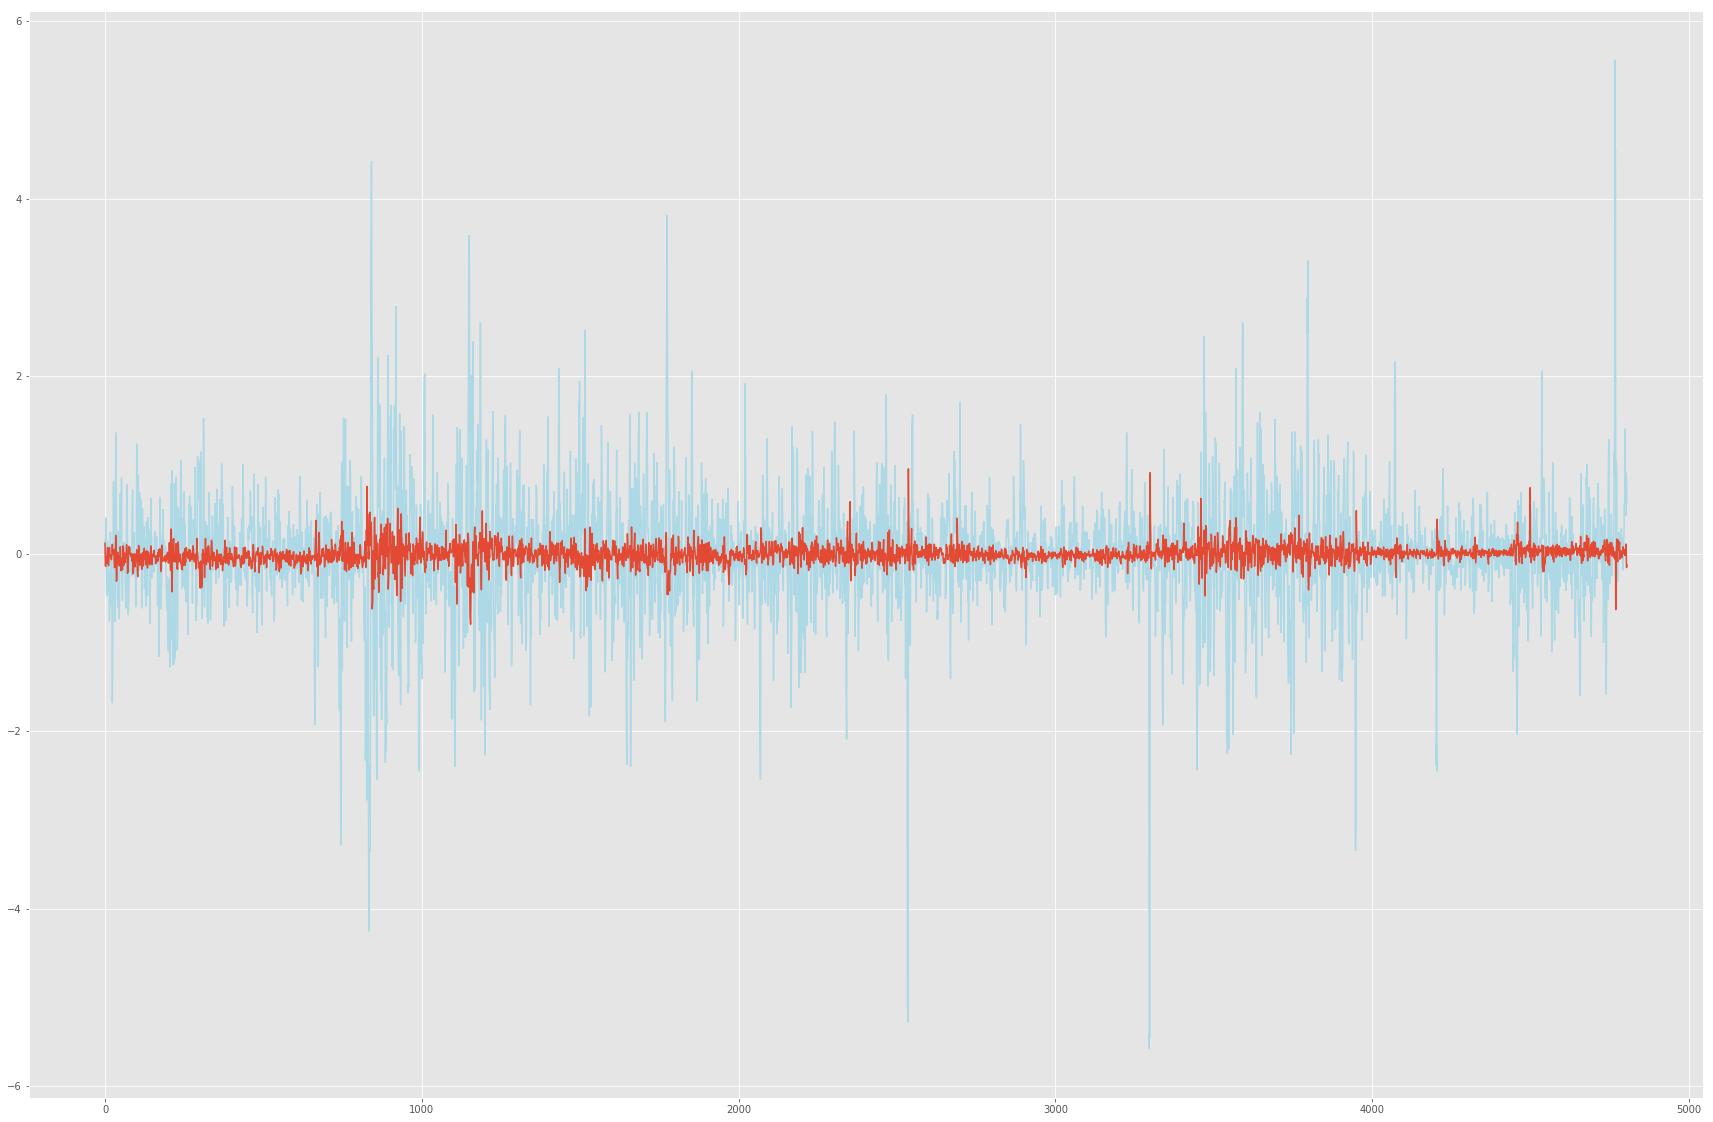

In [88]:
pylab.rcParams['figure.figsize'] = (30, 20)
plt.plot(y_test,color='lightblue')
plt.plot(y_pred)

In [97]:
x_test

array([[ 1.215, -0.169,  0.645, ...,  2.056, -0.487,  2.158],
       [ 0.224, -0.377, -0.247, ...,  2.025, -0.487,  2.692],
       [-0.023, -0.211, -0.284, ...,  2.037, -0.279, -0.547],
       ..., 
       [ 0.373,  0.498,  0.809, ..., -1.331, -0.173, -0.547],
       [-0.221,  0.165, -0.047, ..., -1.314,  0.201, -0.547],
       [ 1.314,  0.998,  0.37 , ..., -1.286,  0.924, -0.547]])

(736743.0, 736802.0)

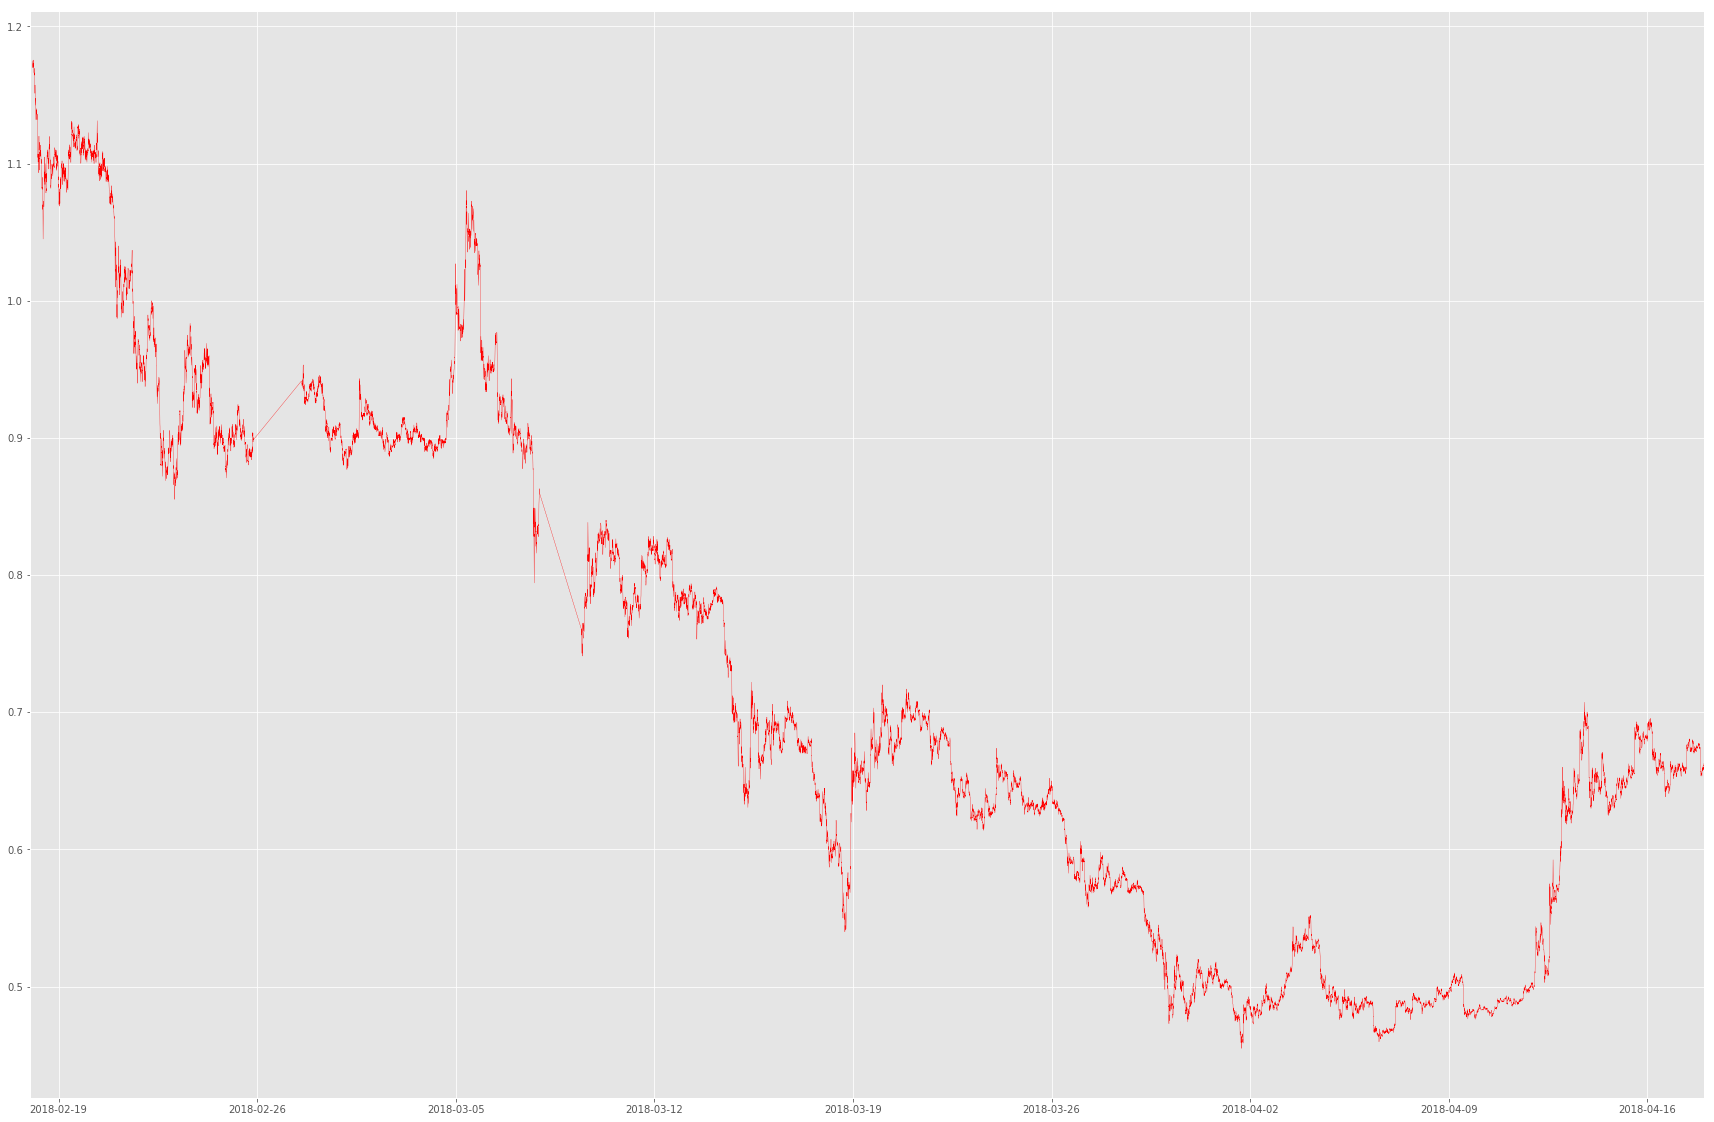

In [95]:
#y_aux = 1 if y_test > 0 else -1
#y_aux2 = 1 if y_pred > 0 else -1


#plt.plot(dfTransacciones['FECHA'], dfTransacciones['PRICE'],linewidth=0.3,color='lightblue')



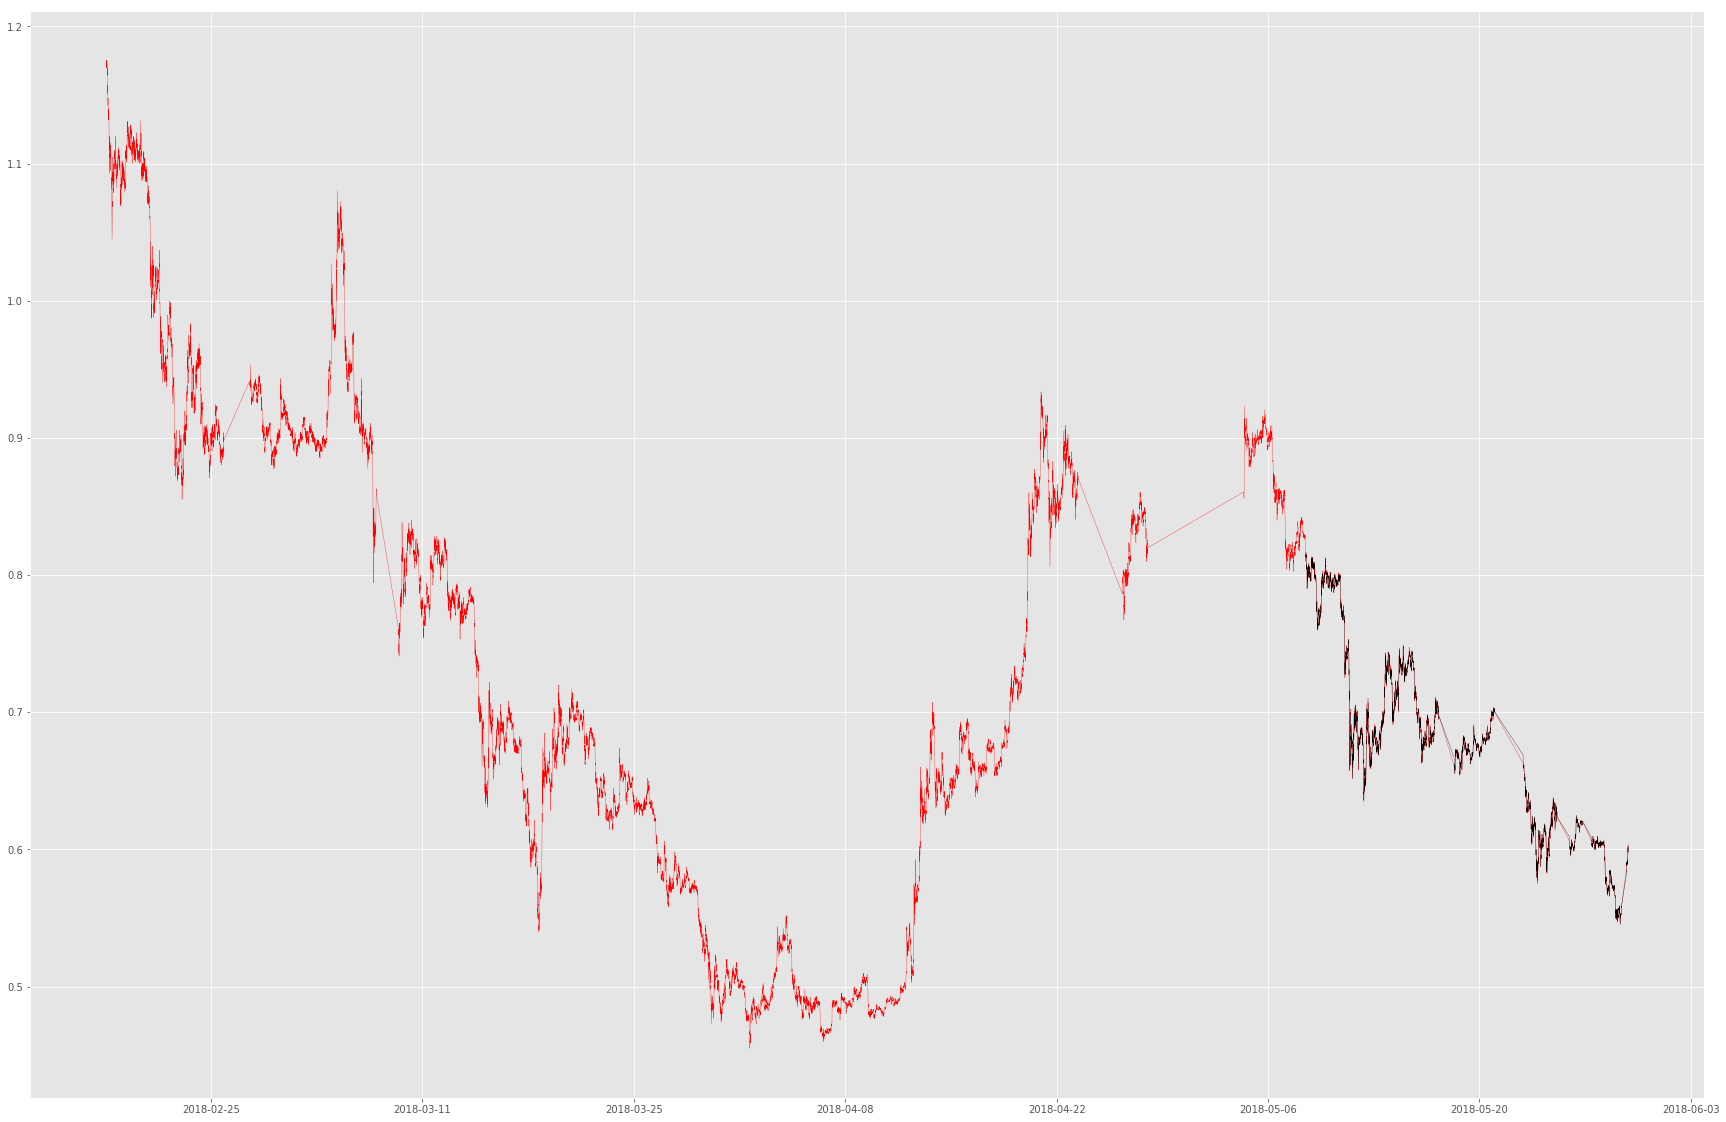

In [110]:
#plt.xlim('2018-02-18','2018-05-30')

split_row = len(dfFinal) - int(0.2 * len(dfFinal))
train_data = dfFinal.iloc[:split_row]
test_data = dfFinal.iloc[split_row:]

plt.plot(dfFinal.index, dfFinal["CLOSE"],linewidth=0.3,color='red')
plt.plot(test_data.index, test_data["CLOSE"] + y_pred * test_data["CLOSE"] / 100,linewidth=0.3,color='black')
plt.show()

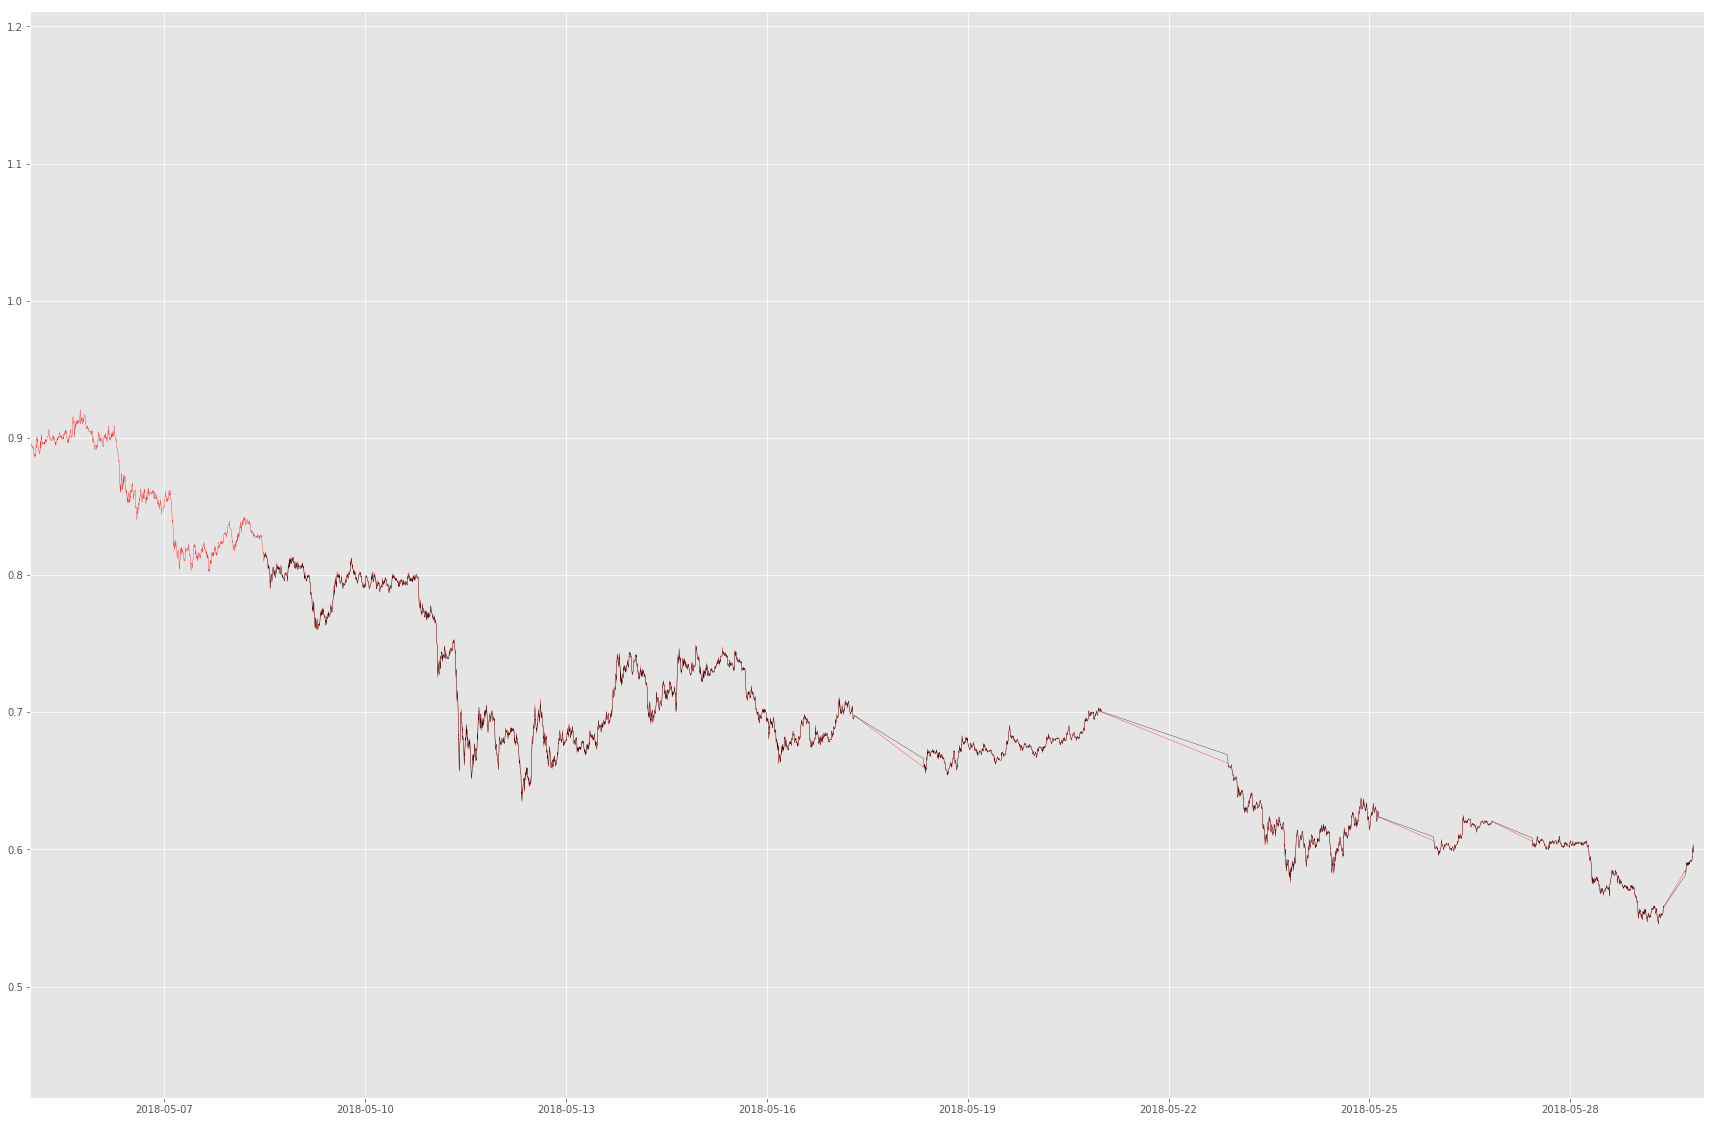

In [120]:
#

split_row = len(dfFinal) - int(0.2 * len(dfFinal))
train_data = dfFinal.iloc[:split_row]
test_data = dfFinal.iloc[split_row:]

plt.plot(dfFinal.index, dfFinal["CLOSE"],linewidth=0.3,color='red')
plt.plot(test_data.index, test_data["CLOSE"] + y_pred * test_data["CLOSE"] / 100,linewidth=0.3,color='black')
plt.xlim('2018-05-05','2018-05-30')
plt.show()

In [81]:
#dfFinal.shape
#len(y_pred)
len(dfFinal["CLOSE"])

24028

In [71]:
#plt.scatter(y_test,dfFinal["CLOSE"],color=['green'],s =10)
#plt.scatter(y_pred,dfFinal["CLOSE"],color=['green'],s =10)

In [ ]:
    if(tipo==modeloRegresion.XGBRegressorLogistic): 
        nombre = "XGB_Logistic"
        modelo = xgb.XGBRegressor(max_depth=3, min_child_weight=10, subsample=0.5,
                colsample_bytree=0.6, objective='binary:logistic', n_estimators=1000,
                learning_rate=0.3)

In [ ]:
def calculaModelo(model,nombre, X_ent, X_test, y_ent, y_test):
    model.fit(X_ent,y_ent)   
    y_pred = model.predict(X_test)
    mae, mse, rmse = calculaMetricas(y_test, y_pred) 
    new_row = [nombre, mae,mse,rmse,'']
    return new_row

In [ ]:
def probarAlgoritmos(X_ent, X_test, y_ent, y_test):
  
    start = time.time()
    
    dfResultados = pd.DataFrame(columns=('ALGORITMO','MAE','MSE','RMSE','PARÁMETROS'))    
    
    ##########################
    #### REGRESIÓN LINEAL ####
    ##########################
    start = time.time()
    nombre = "REGRESION LINEAL"
    model = LinearRegression()  
    new_row = calculaModelo(model,nombre, X_ent, X_test, y_ent, y_test)
    dfResultados.loc[len(dfResultados)] = new_row               
    del model
    
    print(mensajeAlgoritmo(start,nombre))
    
    ###############
    #### RIDGE ####
    ###############
    start = time.time()
    nombre = "RIDGE"
    model = Ridge()  
    new_row = calculaModelo(model,nombre, X_ent, X_test, y_ent, y_test)
    dfResultados.loc[len(dfResultados)] = new_row               
    del model
    
    print(mensajeAlgoritmo(start,nombre))
        
    ##########################
    #### SVM SRV (linear) ####
    ########################## 
    start = time.time()
    nombre = "RIDGE"
    model = svm.SVR(kernel='linear', C=1e3) 
    new_row = calculaModelo(model,nombre, X_ent, X_test, y_ent, y_test)
    dfResultados.loc[len(dfResultados)] = new_row               
    del model
    
    print(mensajeAlgoritmo(start,nombre))

    ########################
    #### SVM SRV (poly) ####
    ######################## 
    start = time.time()
    model = svm.SVR(kernel='poly', C=1e3, degree=2)
    model.fit(X_ent, y_ent)    
    y_pred = model.predict(X_test)
    mae, mse, rmse = calculaMetricas(y_test, y_pred)    
    new_row = ['SVM SVR (poly)', mae,mse,rmse,'']
    dfResultados.loc[len(dfResultados)] = new_row 
    del model
    
    
    #######################
    #### SVM SRV (rbf) ####
    #######################
    start = time.time()
    model = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    model.fit(X_ent, y_ent)    
    y_pred = model.predict(X_test)
    mae, mse, rmse = calculaMetricas(y_test, y_pred)    
    new_row = ['SVM SVR (rbf)', mae,mse,rmse,'']
    resumen.loc[len(resumen)] = new_row 
    del model
    
    
    return dfResultados


In [ ]:
X = np.array(dfFinal.drop(['PRONOSTICO'],1))
X = preprocessing.scale(X)
y = np.array(dfFinal['PRONOSTICO'])

x_ent, x_test, y_ent, y_test = cross_validation.train_test_split(X,y,test_size=0.2)
probarAlgoritmos(x_train, x_test, y_train, y_test)

In [ ]:
def probarAlgoritmos2(X_ent, X_test, y_ent, y_test):
    
    # TODO
    # 
    # 1. CONTROL SOBREAJUSTE
    # 2. MEDIR CON TODAS LAS MÉTRICAS POSIBLES
    # 3. CROSS VALIDATION...
    # OTROS ALGORITMOS
    
    #print("COMIENZA EL PROCESO")
    
    resumen = pd.DataFrame(columns=('ALGORITMO','MAE','MSE','RMSE','PARÁMETROS'))    
    start = time.time()
    
    print("EJECUTANDOSE REGRESIÓN LINEAL...")
    ##########################
    #### REGRESIÓN LINEAL ####
    ##########################
    nombre = "REGRESION LINEAL"
    model = LinearRegression()  
    new_row = calculaModelo(model,nombre, X_ent, X_test, y_ent, y_test)
    resumen.loc[len(resumen)] = new_row               
    del model
    
    print(mensajeAlgoritmo(start,nombre))
    start = time.time()
    
    ###############
    #### RIDGE ####
    ###############
    nombre = "RIDGE"
    model = Ridge()  
    new_row = calculaModelo(model,nombre, X_ent, X_test, y_ent, y_test)
    resumen.loc[len(resumen)] = new_row               
    del model
    
    print(mensajeAlgoritmo(start,nombre))
    start = time.time()
   
    ##########################
    #### SVM SRV (linear) ####
    ########################## 
    nombre = "RIDGE"
    model = svm.SVR(kernel='linear', C=1e3) 
    new_row = calculaModelo(model,nombre, X_ent, X_test, y_ent, y_test)
    resumen.loc[len(resumen)] = new_row               
    del model
    
    print(mensajeAlgoritmo(start,nombre))
    start = time.time()
    
    '''
    #######################
    #### SVM SRV (poly) ####
    #######################    
    model = svm.SVR(kernel='poly', C=1e3, degree=2)
    model.fit(X_ent, y_ent)    
    y_pred = model.predict(X_test)
    mae, mse, rmse = calculaMetricas(y_test, y_pred)    
    new_row = ['SVM SVR (poly)', mae,mse,rmse,'']
    resumen.loc[len(resumen)] = new_row 
    del model
    
    segundos = time.time() - start
    if(segundos < 0):
          mensaje = "SVM SVR (poly) - PROCESADO EN < 1 seg"
    else:
          mensaje = "SVM SVR (poly) - PROCESADO EN " + str(time.time() - start) + " seg."              
    print(mensaje)
    start = time.time()
    
    #######################
    #### SVM SRV (rbf) ####
    #######################    
    model = svm.SVR(kernel='rbf', C=1e3, gamma=0.1)
    model.fit(X_ent, y_ent)    
    y_pred = model.predict(X_test)
    mae, mse, rmse = calculaMetricas(y_test, y_pred)    
    new_row = ['SVM SVR (rbf)', mae,mse,rmse,'']
    resumen.loc[len(resumen)] = new_row 
    del model
    
    segundos = time.time() - start
    if(segundos < 0):
          mensaje = "SVM SVR (rbf) - PROCESADO EN < 1 seg"
    else:
          mensaje = "SVM SVR (rbf) - PROCESADO EN " + str(time.time() - start) + " seg."              
    print(mensaje)
    start = time.time()
    
    #model = svm.SVC()
    #model.fit(X_ent,y_ent.astype('int'))
    #score = clf.score(X_test,y_test.astype('int'))
    '''

    # K-VECINOS
    '''
    mejorNumVecinos =0
    mejorScoreKNN = 0

    for i in range(1,10):
        knn = KNeighborsRegressor(n_neighbors=i)
        knn.fit(X_ent, y_ent)
        score = knn.score(X_test,y_test)
        if(score >mejorScoreKNN): 
            mejorScoreKNN = score
            mejorNumVecinos = i
     
    mae =  metrics.mean_absolute_error(y_test, y_pred)
    mse = metrics.mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(metrics.mean_squared_error(y_test, y_pred))
     
    new_row = ['K-VECINOS', mae,mse,rmse,n_neighbors:%s' %mejorNumVecinos]
    
    #new_row = ['K-VECINOS',mejorScoreKNN,'n_neighbors:%s' %mejorNumVecinos]
    resumen.loc[len(resumen)] = new_row 
        
    del knn
    
    print("PROCESANDOSE K-VECINOS(" + str(time.time() - start) + ")")
    start = time.time()
    '''


    
    '''
    print("ÁRBOL DE DECISIÓN...")
    # ARBOL DE DECISION
    mejorProfundidad = 0
    mejorScoreTree = 0
    for i in range(1,6):
        arbol = DecisionTreeRegressor(max_depth=i)
        arbol.fit(X_ent,y_ent)
        mejorScoreTree = arbol.score(X_test,y_test)
        
        if(score>mejorScoreTree):
            mejorScoreTree = score
            mejorProfundidad = i        
    
    new_row = ['ÁRBOL DE DECISIÓN',mejorScoreTree,'max_depth:%s' %mejorProfundidad]
    resumen.loc[len(resumen)] = new_row 
    
    del arbol    
    
    print("PROCESANDOSE RANDOM FOREST...")
    #Random forest
    score = 0
    clf = RandomForestClassifier(n_jobs=2, random_state=0)
    clf.fit(X_ent,y_ent.astype('int'))
    score = clf.score(X_test,y_test.astype('int'))
    
    new_row = ['RANDOM FOREST',score,'']
    resumen.loc[len(resumen)] = new_row  
    
    print("PROCESANDOSE XGBOOST...")
    # XGboost
    mejorProfundidad = 0
    mejorScoreXGBoost = 0
    for profundidad in range(2,6):
        gbm = xgb.XGBClassifier(max_depth=profundidad, n_estimators=300, learning_rate=0.05)
        gbm.fit(X_ent,y_ent)
        score = gbm.score(X_test,y_test)
        
        if(score>mejorScoreXGBoost):
            mejorScoreXGBoost = score
            mejorProfundidad = profundidad     
    
    new_row = ['XGBOOST',mejorScoreXGBoost,'max_depth:%s' %mejorProfundidad]
    resumen.loc[len(resumen)] = new_row  
    '''
        
    return resumen
    

In [ ]:
#########################################
######### VARIABLES ENTRADA #############
#########################################

numeroRegAnteriores = 10

dfFinal = dfAgrupado

for i in range(1, numeroRegAnteriores+1):
    dfAux =  dfAgrupado.shift(i)
    etiqueta = '_t(' + str(i) + ')'
    dfAux.columns = ['NUM_T_COMPRA' + etiqueta,
                     'NUM_T_VENTA' + etiqueta,
                     'CANTIDAD_COMPRA'  + etiqueta,
                     'CANTIDAD_VENTA' + etiqueta, 
                     'VAR_MAX' + etiqueta,
                     'VAR_INTERVALO' + etiqueta,
                     'CLOSE' + etiqueta]
    dfFinal = pd.concat([dfFinal, dfAux], axis=1)

    
#########################################
######### VARIABLE SALIDA ###############
#########################################
#forecast_out = int(math.ceil(0.01*len(dfAgrupado)))

#numero de intervalos del horizonte
numIntervarlosHorizonte = 3
dfFinal['PRONOSTICO'] = dfFinal['VAR_INTERVALO'].shift(-numIntervarlosHorizonte)
dfFinal = dfFinal.dropna()
#dfFinal.head()

In [ ]:
#dfFinal['PEPE'] = dfFinal[ 1 if dfFinal['PRONOSTICO'] > 0 ELSE 0]
#dfFinal['PRONOSTICO'] = np.where(dfFinal['PRONOSTICO']>0, 1, 0)
#dfFinal.head()


In [ ]:
#ris = load_iris()
#X_ent, X_test, y_ent, y_test = train_test_split(iris.data, iris.target)
#probarAlgoritmos(X_ent, X_test, y_ent, y_test)
X = np.array(dfFinal.drop(['PRONOSTICO'],1))
X = preprocessing.scale(X)
y = np.array(dfFinal['PRONOSTICO'])

x_train, x_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)
probarAlgoritmos(x_train, x_test, y_train, y_test)



In [ ]:
#import statsmodels.api as sm
#model = sm.OLS(y, X).fit()
#predictions = model.predict(X) # make the predictions by the model

# Print out the statistics
#model.summary()

In [ ]:
#X = np.array(dfFinal.drop(['PRONOSTICO'],1))
#X = preprocessing.scale(X)
#y = np.array(dfFinal['PRONOSTICO'])
#x_train, x_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)

# MODELO
#clf = LinearRegression(n_jobs=-1) 

# ENTRENAMOS
#clf.fit(x_train,y_train)

# PRECISION DE ACIERTO
#accuracy = clf.score(x_test, y_test)


In [ ]:
#cols = dfFinal.columns
#sns.pairplot(dfFinal[cols], size = 2.5)
#plt.show();

In [ ]:
X = np.array(dfFinal.drop(['PRONOSTICO'],1))
X = preprocessing.scale(X)
y = np.array(dfFinal['PRONOSTICO'])

X_train, X_test, y_train, y_test = cross_validation.train_test_split(X,y,test_size=0.2)


rl = LinearRegression()
rl.fit(X_train,y_train)

y_pred = rl.predict(X_test)  
 
print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred))) 


In [ ]:
dfFinal.describe()

In [ ]:
'''
ALGORITMOS REGRESION

LINEARREGRESION
KNeighborsRegressor
svr_rbf = SVR(kernel='rbf', C=1e3, gamma=0.1)
svr_lin = SVR(kernel='linear', C=1e3)
svr_poly = SVR(kernel='poly', C=1e3, degree=2)

ALGORITMOS CLASIFICACION

    Linear Classifiers: Logistic Regression, Naive Bayes Classifier
    Support Vector Machines
    Decision Trees
    Boosted Trees
    Random Forest
    Neural Networks
    Nearest Neighbor
    
'''

In [ ]:

#X = np.array(dfFinal.drop(['PRONOSTICO'],1))
#X = preprocessing.scale(X)
#y = np.array(dfFinal['PRONOSTICO'
                                          
#tscv = TimeSeriesSplit(n_splits=2)
#X_train, X_test = X[0], X[0]
#y_train, y_test = y[0], y[0]

In [ ]:
plt.hist(y)

In [ ]:
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})  
df

In [ ]:
def pintaBallenas():
    
    pylab.rcParams['figure.figsize'] = (30, 20)
    plt.xticks(rotation='vertical')
    plt.xlabel('Transacciones')
    plt.ylabel('Amount')
    plt.title('BALLENAS VS PRECIO')

    x1 = [pd.to_datetime(d) for d in dfTransBallenas['FECHA']]
    s1 = [d/100000 for d in dfTransBallenas['CANTIDAD']]
    y1 = [1 for d in dfTransBallenas['FECHA']]

    plt.scatter(x1,y1,color=['red'],s=s1)
    plt.plot(dfTransacciones['FECHA'], dfTransacciones['PRICE'],linewidth=1,color='lightblue')
    plt.xlim('2018-02-18','2018-05-25')
    plt.show()